# Advanced Lane Line Finding

### Author: Patrick Barone
### Email: barone.patrick@gmail.com

In [1]:
import cv2
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import pi
from moviepy.editor import VideoFileClip
%matplotlib inline

In [2]:
class ImageProcessor(object):
    def __init__(self):
        """
        Initialize the image pipeline object and load the camera calibrations
        """
        calibration = pickle.load(open('camera_calibration.p', 'rb'))
        self.mtx = calibration['mtx']
        self.dist = calibration['dist']
        self.first_image = True
        self.left_fit = None
        self.right_fit = None

    def process(self, img, show_images = False, diag=True):
        """
        Process a new image frame to identify lane, curvature and lane position
        """
        try:
            self.show_images = show_images
            self.diag = diag

            # Undistort the image
            undist = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
            
            binary_hls = self.hls_threshold(undist,L_thresh=(80,255),S_thresh=(90,255))
            binary_sobel_abs = self.abs_sobel_threshold(undist,(25,200))
            binary_sobel_dir = self.dir_sobel_threshold(undist, (pi/6, pi/2))
            binary_sobel = binary_sobel_abs & binary_sobel_dir
            binary = binary_hls | binary_sobel
            
            binary_color = np.uint8(255.0*binary)
            binary_color = np.dstack([binary_color,binary_color,binary_color])
            

            '''
            binary_HLS_S = self.hls_threshold(undist, S_thresh=(180,255))
            binary_HLS_L = self.hls_threshold(undist, L_thresh=(220,255))
            binary_LUV_L = self.luv_threshold(undist, L_thresh=(220,255))
            binary_LAB_B = self.lab_threshold(undist, B_thresh=(190,255))
            binary = binary_HLS_L | binary_LAB_B
            '''

            if self.show_images:
                '''
                plt.imshow(binary_sobel_abs, cmap='gray')
                plt.title('Sobel Abs')
                plt.show()
                plt.imshow(binary_sobel_dir, cmap='gray')
                plt.title('Sobel Dir')
                plt.show()
                plt.imshow(binary_sobel, cmap='gray')
                plt.title('Sobel Abs&Dir')
                plt.show()
                '''
                plt.imshow(binary, cmap='gray')
                plt.title('Final Composite')
                plt.show()

            # Perspective transformation
            offset_x = 400
            offset_y = 0
            img_size = (img.shape[1],img.shape[0])
            src = np.float32([[607,443],[673,443],[1020,666],[285,666]])
            dst = np.float32([[offset_x, offset_y], 
                              [img_size[0]-offset_x, offset_y], 
                              [img_size[0]-offset_x, img_size[1]-offset_y], 
                              [offset_x, img_size[1]-offset_y]])

            self.M = cv2.getPerspectiveTransform(src, dst)
            self.Minv = cv2.getPerspectiveTransform(dst, src)
            x = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)
            warped_color = cv2.warpPerspective(x, self.M, img_size)
            warped = cv2.cvtColor(warped_color, cv2.COLOR_RGB2GRAY)

            if self.show_images:
                plt.imshow(warped, cmap='gray')
                plt.show()

            if self.first_image:
                hist, self.left_fit, self.right_fit = self.find_lanes(warped)
                self.first_image = False
            else:
                hist, self.left_fit, self.right_fit = self.find_lanes_given_prev(warped, self.left_fit, self.right_fit)

            output = self.draw_lanes_on_orig(undist, binary, self.left_fit, self.right_fit)
                
            if self.diag:
                top_row = np.hstack([output,binary_color])
                bottom_row = np.hstack([np.uint8(255*warped_color),np.zeros_like(output,dtype=np.uint8)])
                output = np.vstack([top_row,bottom_row])
                
            if self.show_images:
                plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
                plt.show()
                
            return output

        except Exception as ex:            
            print('Unable to process lane: ' + str(ex))
            self.first_image = True
            return img
    
    def hls_threshold(self,img, H_thresh=None, L_thresh=None, S_thresh=None):
        """
        Return a binary image with HLS thresholding of BGR input image
        """
        # Color space transformations
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        H = hls[:,:,0]
        L = hls[:,:,1]
        S = hls[:,:,2]

        binary = np.ones_like(H)
        
        # Color space thresholding
        if H_thresh is not None:
            binary_H = np.zeros_like(H)
            binary_H[(H>H_thresh[0]) & (H<=H_thresh[1])] = 1
            binary = binary & binary_H
            if self.show_images:
                plt.imshow(binary_H, cmap='gray')
                plt.title('H_thresh')
                plt.show()
            
        if L_thresh is not None:
            binary_L = np.zeros_like(L)
            binary_L[(L>L_thresh[0]) & (L<=L_thresh[1])] = 1
            binary = binary & binary_L
            if self.show_images:
                plt.imshow(binary_L, cmap='gray')
                plt.title('L_thresh')
                plt.show()
            
        if S_thresh is not None:
            binary_S = np.zeros_like(S)
            binary_S[(S>S_thresh[0]) & (S<=S_thresh[1])] = 1
            binary = binary & binary_S
            if self.show_images:
                plt.imshow(binary_S, cmap='gray')
                plt.title('S_thresh')
                plt.show()

        return binary
    
    def luv_threshold(self,img, L_thresh=None, U_thresh=None, V_thresh=None):
        """
        Return a binary image with LUV thresholding of BGR input image
        """
        # Color space transformations
        luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        L = luv[:,:,0]
        U = luv[:,:,1]
        V = luv[:,:,2]

        binary = np.ones_like(L)
        
        # Color space thresholding            
        if L_thresh is not None:
            binary_L = np.zeros_like(L)
            binary_L[(L>L_thresh[0]) & (L<=L_thresh[1])] = 1
            binary = binary & binary_L
            if self.show_images:
                plt.imshow(binary_L, cmap='gray')
                plt.title('L_thresh')
                plt.show()
                
        if U_thresh is not None:
            binary_U = np.zeros_like(U)
            binary_U[(U>U_thresh[0]) & (U<=U_thresh[1])] = 1
            binary = binary & binary_U
            if self.show_images:
                plt.imshow(binary_U, cmap='gray')
                plt.title('U_thresh')
                plt.show()
            
        if V_thresh is not None:
            binary_V = np.zeros_like(V)
            binary_V[(V>V_thresh[0]) & (V<=V_thresh[1])] = 1
            binary = binary & binary_V
            if self.show_images:
                plt.imshow(binary_V, cmap='gray')
                plt.title('V_thresh')
                plt.show()
            
        return binary
    
    def lab_threshold(self,img, L_thresh=None, A_thresh=None, B_thresh=None):
        """
        Return a binary image with LAB thresholding of BGR input image
        """
        # Color space transformations
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
        L = lab[:,:,0]
        A = lab[:,:,1]
        B = lab[:,:,2]

        binary = np.ones_like(L)
        
        # Color space thresholding            
        if L_thresh is not None:
            binary_L = np.zeros_like(L)
            binary_L[(L>L_thresh[0]) & (L<=L_thresh[1])] = 1
            binary = binary & binary_L
            if self.show_images:
                plt.imshow(binary_L, cmap='gray')
                plt.title('L_thresh')
                plt.show()
                
        if A_thresh is not None:
            binary_A = np.zeros_like(A)
            binary_A[(A>A_thresh[0]) & (A<=A_thresh[1])] = 1
            binary = binary & binary_A
            if self.show_images:
                plt.imshow(binary_A, cmap='gray')
                plt.title('A_thresh')
                plt.show()
            
        if B_thresh is not None:
            binary_B = np.zeros_like(B)
            binary_B[(B>B_thresh[0]) & (B<=B_thresh[1])] = 1
            binary = binary & binary_B
            if self.show_images:
                plt.imshow(binary_B, cmap='gray')
                plt.title('B_thresh')
                plt.show()
            
        return binary
    
    def sobel_threshold(self,img, thresh, orient='x'):
        """
        Return binary x or y sobel threshold image
        """
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        return binary_output
    
    def abs_sobel_threshold(self, img, thresh):
        """
        Return binary solbel magnitude threshold image
        """
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
        sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        sobel_abs = np.sqrt(sobel_x**2 + sobel_y**2)
        scaled_sobel = np.uint8(255*sobel_abs/np.max(sobel_abs))
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        return binary_output
    
    def dir_sobel_threshold(self, img, thresh):
        """
        Return binary sobel direction threshold image
        """
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
        sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        sobel_dir = np.arctan2(sobel_x, sobel_y)
        sobel_dir = np.abs(sobel_dir)
        
        if self.show_images:
            plt.imshow(sobel_dir, cmap='gray')
            plt.title('SobelDir')
            plt.show()
        
        binary_output = np.zeros_like(gray)
        binary_output[(sobel_dir >= thresh[0]) & (sobel_dir <= thresh[1])] = 1
        return binary_output
    
    def find_lanes(self, img):
        """
        Idenfity the lane lines in a given binary image with perspective transform already applied
        """
        histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
        out_img = np.dstack((img, img, img))*255
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(img.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        '''
        fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
        '''
        
        return out_img, left_fit, right_fit
    
    def find_lanes_given_prev(self,img, left_fit, right_fit):
        """
        Identify lane lines like find_lanes() but given the previous lane lines
        """
        out_img = np.dstack((img, img, img))*255
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]        
        
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
        right_fit_new = np.polyfit(righty, rightx, 2)
        
        # Average using an IIR filter to smooth our disturbances
        alpha = 0.8
        left_fit_final = alpha * left_fit + (1.0 - alpha) * left_fit_new
        right_fit_final = alpha * right_fit + (1.0 - alpha) * right_fit_new

        
        return None, left_fit_final, right_fit_final
    
    def draw_lanes_on_orig(self, orig_image, binary_img, left_fit, right_fit):
        """
        Draw the identified lane lines on the original image
        """
        output = np.copy(orig_image)
        img1 = np.zeros((binary_img.shape[0], binary_img.shape[1], 3), dtype=np.uint8)
        h,w = binary_img.shape
        y_lines = np.linspace(0,h-1, num=h)
        x_left = np.polyval(left_fit, y_lines)
        x_right = np.polyval(right_fit, y_lines)
        x_left_pts = np.array([x_left, y_lines]).T
        x_right_pts = np.array([x_right, y_lines]).T
        pts = np.concatenate([x_left_pts,np.flip(x_right_pts,0)], axis=0)
        
        cv2.fillPoly(img1, np.int_([pts]), (0,255,0))
        lane = cv2.warpPerspective(img1, self.Minv, (w,h))
        
        curv_left, curv_right = self.calc_radius_of_curvature(y_lines, x_left, x_right)
        curv_avg = (curv_left+curv_right)/2
        curv_text = 'Radius: %.0fm' % curv_avg
        
        lane_pos = self.calc_lane_position(x_left, x_right, orig_image.shape)
        lane_pos_text = 'Offset: %.3fm' % lane_pos
        
        font = cv2.FONT_HERSHEY_PLAIN
        color = (0,0,255)
        font_size = 3
        line_width = 3
        cv2.putText(output, curv_text, (20,75), font, font_size, color, line_width, cv2.LINE_AA)
        cv2.putText(output, lane_pos_text, (20,150), font, font_size, color, line_width, cv2.LINE_AA)

        output = cv2.addWeighted(output, 1, lane, 0.5, 0)
        return output
    
    def calc_radius_of_curvature(self, ploty, leftx, rightx):
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        y_eval = np.max(ploty)

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        return left_curverad, right_curverad
    
    def calc_lane_position(self, leftx, rightx, imshape):
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
        center_px = (leftx[-1] + rightx[-1])/2
        offset_px = imshape[0] - center_px
        offset_m = xm_per_pix * offset_px
        
        return offset_m

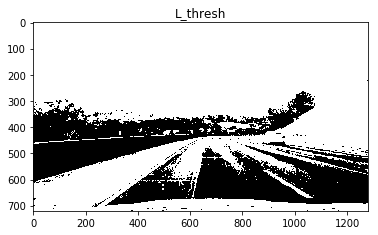

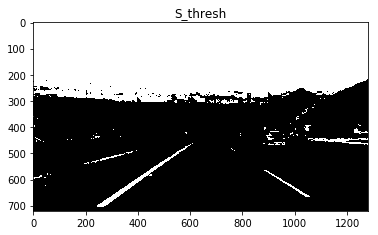

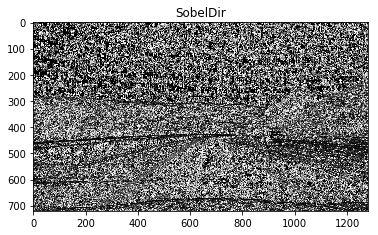

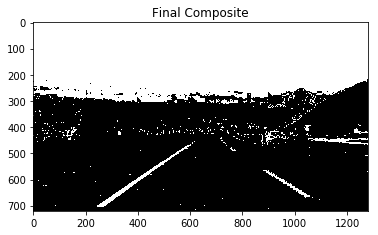

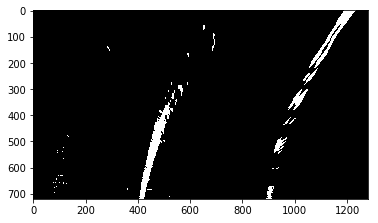

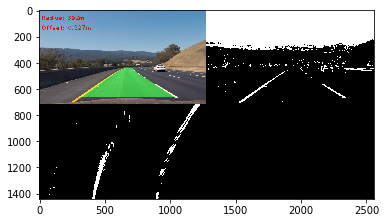

In [3]:
#image_path = './test_images/straight_lines1.jpg'
image_path = './test_images/test3.jpg'
#image_path = './raw_frames/5.jpg'

ip = ImageProcessor()
img = cv2.imread(image_path)
ret = ip.process(img, show_images=True)

In [60]:
# List of all video filenames
filenames = ['project_video.mp4', 'challenge_video.mp4','harder_challenge_video.mp4']
# Select filename to process by changing the index below
filename = filenames[0]

# Process the file selected above using our pipeline
ip2 = ImageProcessor()
white_output = 'test_videos_output/' + filename
clip1 = VideoFileClip(filename)
white_clip = clip1.fl_image(ip2.process) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4



 24%|██▍       | 303/1261 [01:17<04:08,  3.85it/s]


 48%|████▊     | 605/1261 [02:38<02:59,  3.66it/s]


 72%|███████▏  | 907/1261 [03:57<01:32,  3.84it/s]


 96%|█████████▌| 1205/1261 [05:21<00:14,  3.76it/s]


100%|█████████▉| 1260/1261 [05:35<00:00,  3.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 



In [43]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))
